In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [16]:
df = pd.read_csv('/content/drive/MyDrive/VDT2022/mini-project/stroke_recovery_dataset/protocol/sb01.csv')
cols = ['counts', 'speed']
data_df = df.loc[df.index, cols]
data_df = data_df.interpolate()

In [20]:
y = data_df['speed']
X = data_df.drop('speed', axis=1)


# # basic train/test split -- you may want a more robust cross-validation approach
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)

# # setting the threshold to the 95th percentile
thr = np.quantile(y_train, .95)

# # transforming the numeric target to a binary one 
y_train_binary = (y_train >= thr).astype(int)
y_test_binary = (y_test >= thr).astype(int)

# # training a probabilistic classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train_binary)

# # predicting exceedance probability
exceedance_prob_clf = classifier.predict_proba(X_test)[:, 1]

In [21]:
# Using the RF as ensemble of trees
from sklearn.ensemble import RandomForestRegressor

# Training the model
forecasting_ensemble = RandomForestRegressor()
# Here we use the numerical target
## which represents the next value of the time series
forecasting_ensemble.fit(X_train, y_train)

# Retrieving the predictions from the trees.
per_tree_pred = [tree.predict(X_test) for tree in forecasting_ensemble.estimators_]
per_tree_df = pd.DataFrame(per_tree_pred).T

# Computing the ratio of trees which predict a value above the threshold
exceedance_prob_fe = per_tree_df.apply(lambda x: np.mean(x > thr), axis=1).values

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature n

In [22]:
from sklearn.metrics import brier_score_loss, roc_auc_score

print("ROC-fe", roc_auc_score(y_true=y_test_binary, y_score=exceedance_prob_fe)) 
print("ROC-clf", roc_auc_score(y_true=y_test_binary, y_score=exceedance_prob_clf))

print("brier-fe", brier_score_loss(y_true=y_test_binary, y_prob=exceedance_prob_fe))
print("brier-clf", brier_score_loss(y_true=y_test_binary, y_prob=exceedance_prob_clf))

ROC-fe 0.25427350427350426
ROC-clf 0.9188034188034189
brier-fe 0.964696694214876
brier-clf 0.14471071135543206


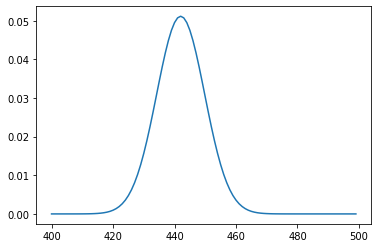

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

#x-axis ranges from -5 and 5 with .001 steps
x = np.arange(400, 500, 1)

#define multiple normal distributions
plt.plot(x, norm.pdf(x, 442, 7.8), label='μ: 0, σ: 1')

In [45]:
y_test.shape

(121,)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


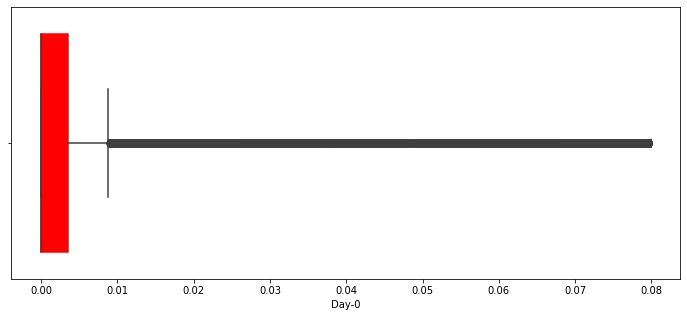

In [62]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt

# n = 480
# ts = pd.Series(np.random.randn(n), index=pd.date_range(start="2014-02-01", periods=n, freq="H"))

df1 = pd.DataFrame()
y = y_test.values
for i in range(9):
    x = np.arange(y[i]-50, y[i]+50, 0.01)
    norm_x = norm.pdf(x, y[i], 5)
    # ts = pd.Series(y_test.values, index=pd.date_range(start="2014-02-01", periods=121, freq="H"))
    df1[f'Day-{i}'] = pd.Series(norm_x)
fig, ax = plt.subplots(figsize=(12,5))
# seaborn.boxplot(ts.index.dayofyear, ts, ax=ax, color="gray")
seaborn.boxplot(df1['Day-0'], boxprops=dict(color='red'))